## Naive Bayes

Import necessary libraries to perform Naive Bayes Classification.

In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.model_selection import GridSearchCV

### Data Prep for ML

Unpickle data and remove any NA values.

Concate "comment" and "parent_comment" for TF-IDF and BoW from training and testing datasets using vstack.

In [2]:
train = pd.read_pickle("data/train.pkl").dropna()
test = pd.read_pickle("data/test.pkl").dropna()

In [3]:
train_parent_tdidf_csr = vstack(train["parent_comment_tdidf"])
test_parent_tdidf_csr = vstack(test["parent_comment_tdidf"])

train_tdidf_csr = vstack(train["comment_tdidf"])
test_tdidf_csr = vstack(test["comment_tdidf"])

train_parent_bow_csr = vstack(train["parent_comment_bow"])
test_parent_bow_csr = vstack(test["parent_comment_bow"])

train_bow_csr = vstack(train["comment_bow"])
test_bow_csr = vstack(test["comment_bow"])

In [4]:
train.columns

Index(['comment', 'parent_comment', 'comment_tokens', 'parent_comment_tokens',
       'comment_tokens_bigram', 'parent_comment_tokens_bigram',
       'comment_tokens_trigram', 'parent_comment_tokens_trigram',
       'comment_score', 'parent_comment_score',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive', 'comment_word_count',
       'parent_comment_word_count', 'comment_token_count',
       'parent_comment_token_count', 'comment_unique_word_count',
       'parent_comment_unique_word_count', 'comment_unique_token_count',
       'parent_comment_unique_token_count', 'comment_stopword_count',
       'parent_comment_stopword_count', 'comment_mean_word_length',
       'parent_comment_mean_word_length', 'comment_mean_token_length',
       'parent_comment_mean_token_length', 'comment_char_count',
       'parent_comment_char_count', 'comment_

List of features necessary for Naive Bayes classification.

In [5]:
list_of_features = [
       'comment_word_count','parent_comment_word_count',
       'comment_token_count', 'parent_comment_token_count',
       'comment_unique_word_count', 'parent_comment_unique_word_count',
       'comment_unique_token_count', 'parent_comment_unique_token_count',
       'comment_stopword_count', 'parent_comment_stopword_count',
       'comment_mean_word_length', 'parent_comment_mean_word_length',
       'comment_mean_token_length', 'parent_comment_mean_token_length',
       'comment_char_count', 'parent_comment_char_count',
       'comment_punctuation_count', 'parent_comment_punctuation_count',
       'comment_hashtag_count', 'parent_comment_hashtag_count',
       'comment_number_count', 'parent_comment_number_count',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive']

Here we will standardize columns with boolean values. We will change from boolean to integer type and convert the features from a dense matrix to a sparse matrix using the function csr_matrix.

In [6]:
bool_cols = ['weighted_parent_sentiment_score_neutral',
             'weighted_parent_sentiment_score_positive',
             'weighted_comment_sentiment_score_neutral',
             'weighted_comment_sentiment_score_positive']

for col in bool_cols: #need to convert bool type to integer
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)
X_train_gen_features = csr_matrix(train[list_of_features])
y_train_LR = train['label']

X_test_gen_features = csr_matrix(test[list_of_features])
y_test_LR = test['label']

### Baseline 1: General Features

Performing Multinomial Naive Bayes classification using General Features as the baseline.

We will first train the training data using the MultinomialNB() model. We will then make predictions and compare the actual values and predicted values using the mean and stardard deviation of the area under the ROC curve. By looking at the difference in the area under curve measurements we can evaluate the accuracy and precision of logistic regression for this dataset.

In [7]:
X_train_LR = X_train_gen_features


In [8]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5053108414551877
Standard Deviation of roc_auc: 0.00491743706424603


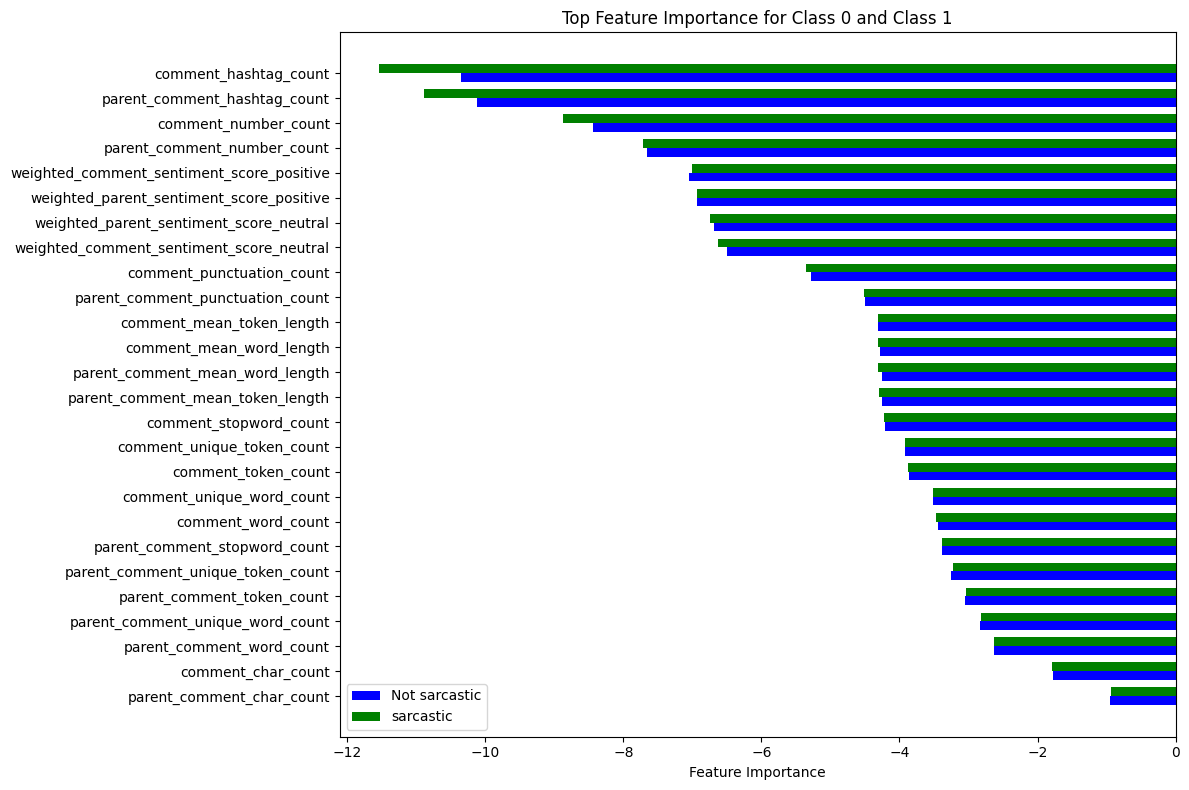

In [9]:
# Plotting feature importance
import matplotlib.pyplot as plt

# Train the model on the entire dataset
model.fit(X_train, y_train)

# Get the feature log probabilities (coefficients) from the model
feature_log_prob = model.feature_log_prob_

# Mapping feature names to importance scores
feature_importance_dict0 = dict(zip(list_of_features, feature_log_prob[0]))
feature_importance_dict1 = dict(zip(list_of_features, feature_log_prob[1]))

# Sort the features by their importance scores for class 0
sorted_features_0 = sorted(feature_importance_dict0.items(), key=lambda x: x[1], reverse=True)
top_features_0 = len(list_of_features)  # Choose how many top features to display for class 0
top_features_names_0 = [feat[0] for feat in sorted_features_0[:top_features_0]]
top_features_scores_0 = [feat[1] for feat in sorted_features_0[:top_features_0]]

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = len(list_of_features)  # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = top_features_0 
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index, top_features_scores_0, bar_width, label='Not sarcastic', color='blue')
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_0)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
sorted_features_0

[('parent_comment_char_count', -0.9524732209674447),
 ('comment_char_count', -1.780548547887383),
 ('parent_comment_word_count', -2.6285693089054387),
 ('parent_comment_unique_word_count', -2.8357639985450014),
 ('parent_comment_token_count', -3.050764957619988),
 ('parent_comment_unique_token_count', -3.2519179581708233),
 ('parent_comment_stopword_count', -3.384090904017139),
 ('comment_word_count', -3.44172371461665),
 ('comment_unique_word_count', -3.5154380364216617),
 ('comment_token_count', -3.8568469618701027),
 ('comment_unique_token_count', -3.9178216752401287),
 ('comment_stopword_count', -4.204037975633723),
 ('parent_comment_mean_token_length', -4.251841312381112),
 ('parent_comment_mean_word_length', -4.256457205370051),
 ('comment_mean_word_length', -4.283553436684938),
 ('comment_mean_token_length', -4.3057218129814885),
 ('parent_comment_punctuation_count', -4.504189670488495),
 ('comment_punctuation_count', -5.28338868854337),
 ('weighted_comment_sentiment_score_neutr

In [11]:
sorted_features_1

[('parent_comment_char_count', -0.9425667253447383),
 ('comment_char_count', -1.7940831264759218),
 ('parent_comment_word_count', -2.6256692400864914),
 ('parent_comment_unique_word_count', -2.8197565315729545),
 ('parent_comment_token_count', -3.0407350769511474),
 ('parent_comment_unique_token_count', -3.2288620102541614),
 ('parent_comment_stopword_count', -3.389325173328263),
 ('comment_word_count', -3.464800599729884),
 ('comment_unique_word_count', -3.513901979525288),
 ('comment_token_count', -3.8803740718932715),
 ('comment_unique_token_count', -3.9203205978004405),
 ('comment_stopword_count', -4.225499317547808),
 ('parent_comment_mean_token_length', -4.2958414237852764),
 ('comment_mean_token_length', -4.3046401184360334),
 ('parent_comment_mean_word_length', -4.306265569690163),
 ('comment_mean_word_length', -4.310281819367001),
 ('parent_comment_punctuation_count', -4.51125044445636),
 ('comment_punctuation_count', -5.349808662176088),
 ('weighted_comment_sentiment_score_ne

### Baseline 2: Comment BoW

Performing Multinomial Naive Bayes classification using Comment Bag of Words as the baseline.

In [12]:
X_train_LR = train_bow_csr

In [13]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6439986874851111
#unigram: Standard Deviation of roc_auc: 0.0015538454889143783

Mean roc_auc: 0.6539451398593382
Standard Deviation of roc_auc: 0.0018663773341545445


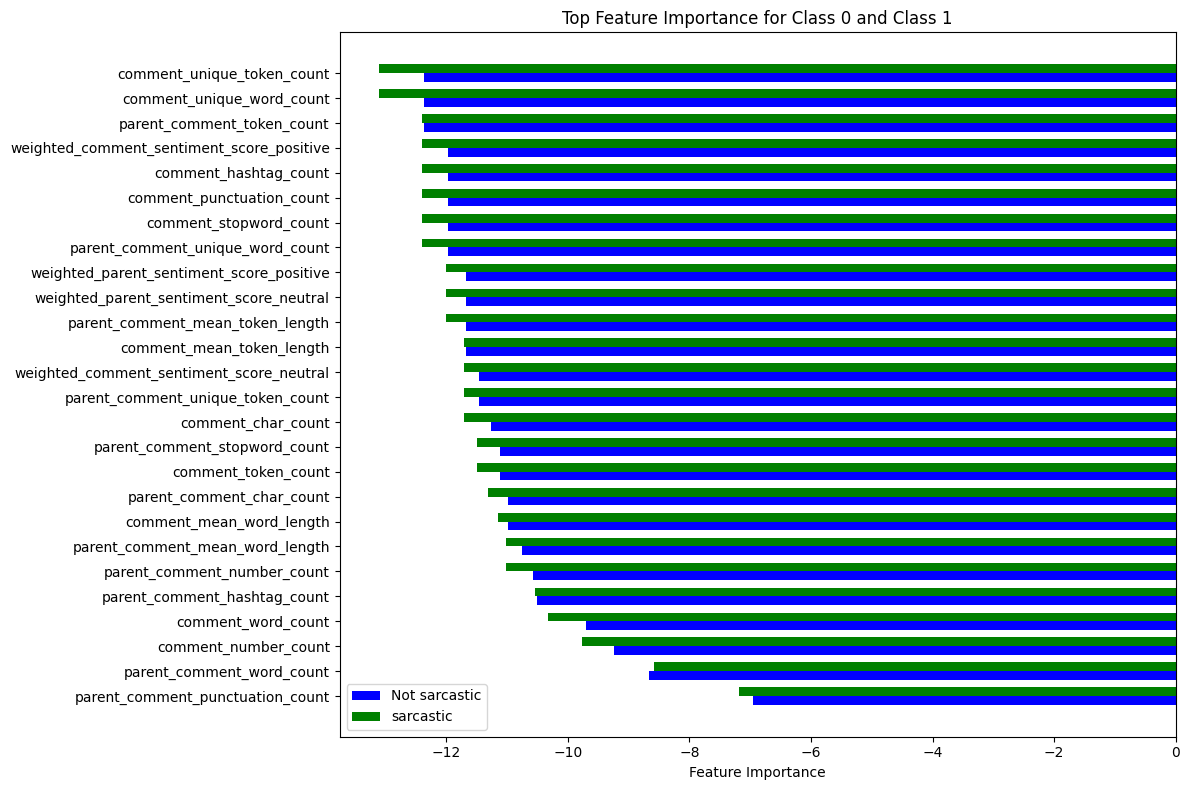

In [14]:
# Get the feature log probabilities (coefficients) from the model
feature_log_prob = model.feature_log_prob_

# Mapping feature names to importance scores
feature_importance_dict0 = dict(zip(list_of_features, feature_log_prob[0]))
feature_importance_dict1 = dict(zip(list_of_features, feature_log_prob[1]))

# Sort the features by their importance scores for class 0
sorted_features_0 = sorted(feature_importance_dict0.items(), key=lambda x: x[1], reverse=True)
top_features_0 = len(list_of_features)  # Choose how many top features to display for class 0
top_features_names_0 = [feat[0] for feat in sorted_features_0[:top_features_0]]
top_features_scores_0 = [feat[1] for feat in sorted_features_0[:top_features_0]]

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = len(list_of_features)  # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = top_features_0 
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index, top_features_scores_0, bar_width, label='Not sarcastic', color='blue')
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_0)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
sorted_features_0

[('parent_comment_punctuation_count', -6.960697102191912),
 ('parent_comment_word_count', -8.658771087342643),
 ('comment_number_count', -9.236848938117802),
 ('comment_word_count', -9.698194504620423),
 ('parent_comment_hashtag_count', -10.500540977145361),
 ('parent_comment_number_count', -10.580583684818897),
 ('parent_comment_mean_word_length', -10.762905241612852),
 ('comment_mean_word_length', -10.986048792927061),
 ('parent_comment_char_count', -10.986048792927061),
 ('comment_token_count', -11.119580185551584),
 ('parent_comment_stopword_count', -11.119580185551584),
 ('comment_char_count', -11.273730865378843),
 ('parent_comment_unique_token_count', -11.456052422172798),
 ('weighted_comment_sentiment_score_neutral', -11.456052422172798),
 ('comment_mean_token_length', -11.679195973487007),
 ('parent_comment_mean_token_length', -11.679195973487007),
 ('weighted_parent_sentiment_score_neutral', -11.679195973487007),
 ('weighted_parent_sentiment_score_positive', -11.6791959734870

In [16]:
sorted_features_1

[('parent_comment_punctuation_count', -7.180223002247618),
 ('parent_comment_word_count', -8.590941915374584),
 ('comment_number_count', -9.76959691171623),
 ('parent_comment_unique_token_count', -10.329212699651652),
 ('parent_comment_hashtag_count', -10.536852064429898),
 ('comment_word_count', -11.022359880211598),
 ('comment_token_count', -11.022359880211598),
 ('parent_comment_stopword_count', -11.15589127283612),
 ('comment_stopword_count', -11.31004195266338),
 ('comment_unique_word_count', -11.492363509457334),
 ('parent_comment_mean_word_length', -11.492363509457334),
 ('comment_mean_token_length', -11.715507060771543),
 ('parent_comment_mean_token_length', -11.715507060771543),
 ('parent_comment_char_count', -11.715507060771543),
 ('weighted_comment_sentiment_score_neutral', -11.715507060771543),
 ('comment_unique_token_count', -12.003189133223325),
 ('comment_hashtag_count', -12.003189133223325),
 ('parent_comment_number_count', -12.003189133223325),
 ('parent_comment_token_

### Baseline 3: Comment TF-IDF

Performing Multinomial Naive Bayes classification using Comment TF-idf as the baseline.

In [17]:
X_train_LR = train_tdidf_csr

In [18]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6392604315512
#unigram: Standard Deviation of roc_auc: 0.0014945661295342496

Mean roc_auc: 0.6516729123224697
Standard Deviation of roc_auc: 0.0016794671113447989


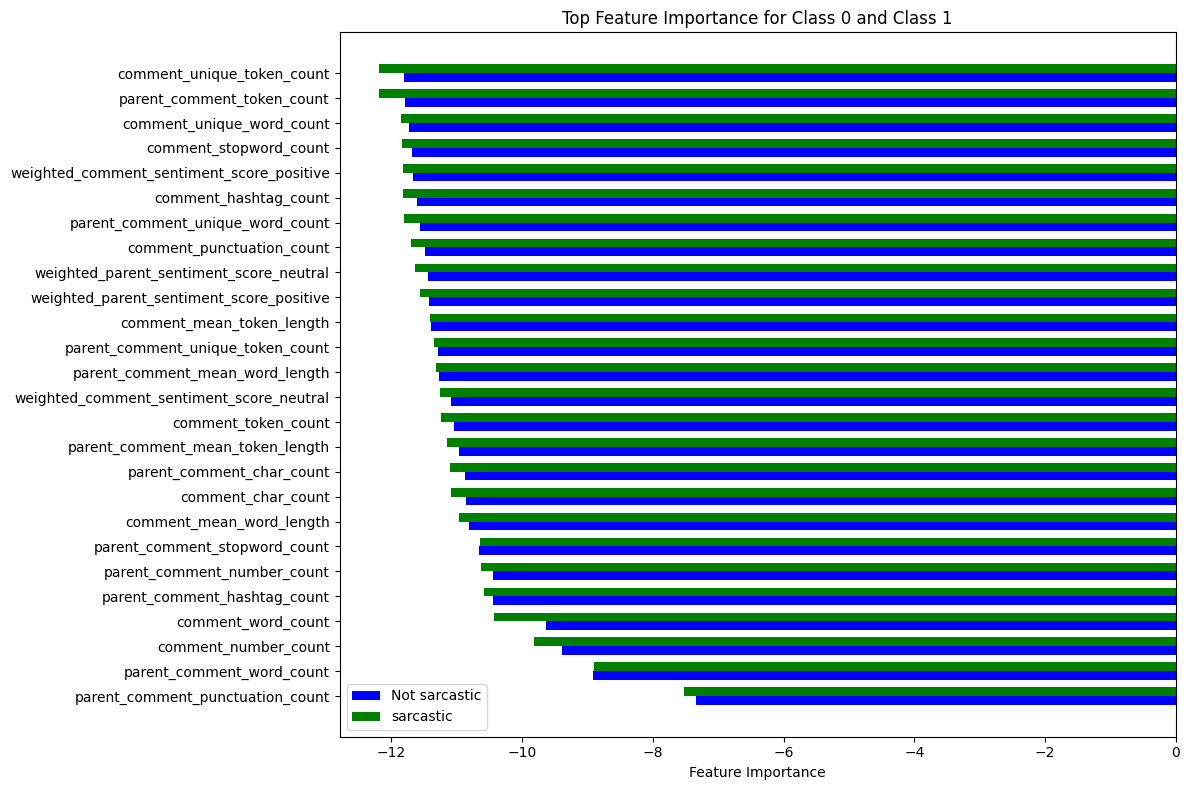

In [19]:
# Get the feature log probabilities (coefficients) from the model
feature_log_prob = model.feature_log_prob_

# Mapping feature names to importance scores
feature_importance_dict0 = dict(zip(list_of_features, feature_log_prob[0]))
feature_importance_dict1 = dict(zip(list_of_features, feature_log_prob[1]))

# Sort the features by their importance scores for class 0
sorted_features_0 = sorted(feature_importance_dict0.items(), key=lambda x: x[1], reverse=True)
top_features_0 = len(list_of_features)  # Choose how many top features to display for class 0
top_features_names_0 = [feat[0] for feat in sorted_features_0[:top_features_0]]
top_features_scores_0 = [feat[1] for feat in sorted_features_0[:top_features_0]]

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = len(list_of_features)  # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = top_features_0 
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index, top_features_scores_0, bar_width, label='Not sarcastic', color='blue')
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_0)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
sorted_features_0

[('parent_comment_punctuation_count', -7.336175997392329),
 ('parent_comment_word_count', -8.917747353180355),
 ('comment_number_count', -9.397387744370878),
 ('comment_word_count', -9.635850460152827),
 ('parent_comment_hashtag_count', -10.4387287090773),
 ('parent_comment_number_count', -10.444156992934845),
 ('parent_comment_stopword_count', -10.663096029498593),
 ('comment_mean_word_length', -10.815787874441902),
 ('comment_char_count', -10.864081283638885),
 ('parent_comment_char_count', -10.87104517923563),
 ('parent_comment_mean_token_length', -10.971601383693002),
 ('comment_token_count', -11.046945328028617),
 ('weighted_comment_sentiment_score_neutral', -11.090463670781586),
 ('parent_comment_mean_word_length', -11.271482164217916),
 ('parent_comment_unique_token_count', -11.288724529145481),
 ('comment_mean_token_length', -11.390261245748581),
 ('weighted_parent_sentiment_score_positive', -11.42332188175512),
 ('weighted_parent_sentiment_score_neutral', -11.444535528535198),

In [21]:
sorted_features_1

[('parent_comment_punctuation_count', -7.529609005607015),
 ('parent_comment_word_count', -8.906021875848083),
 ('comment_number_count', -9.812782842419193),
 ('parent_comment_unique_token_count', -10.43603192357303),
 ('parent_comment_hashtag_count', -10.585564887043208),
 ('comment_word_count', -10.630783392403838),
 ('parent_comment_stopword_count', -10.64553747964663),
 ('comment_token_count', -10.972214320912789),
 ('comment_stopword_count', -11.08979845603588),
 ('parent_comment_mean_token_length', -11.106122224032118),
 ('parent_comment_mean_word_length', -11.146549295284563),
 ('comment_mean_token_length', -11.238212839937992),
 ('weighted_comment_sentiment_score_neutral', -11.257020439789795),
 ('comment_unique_word_count', -11.312899283652058),
 ('comment_hashtag_count', -11.349776584429858),
 ('parent_comment_char_count', -11.416056041968652),
 ('comment_unique_token_count', -11.566953982138743),
 ('parent_comment_number_count', -11.63461889475393),
 ('comment_punctuation_co

### Baseline 4: General Features + BoW

Performing Multinomial Naive Bayes classification using both General Features and Comment Bag of Words as the baseline.

In [22]:
X_train_LR = hstack([X_train_gen_features,train_bow_csr])

In [23]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.6346011511337147
Standard Deviation of roc_auc: 0.009129336279886418


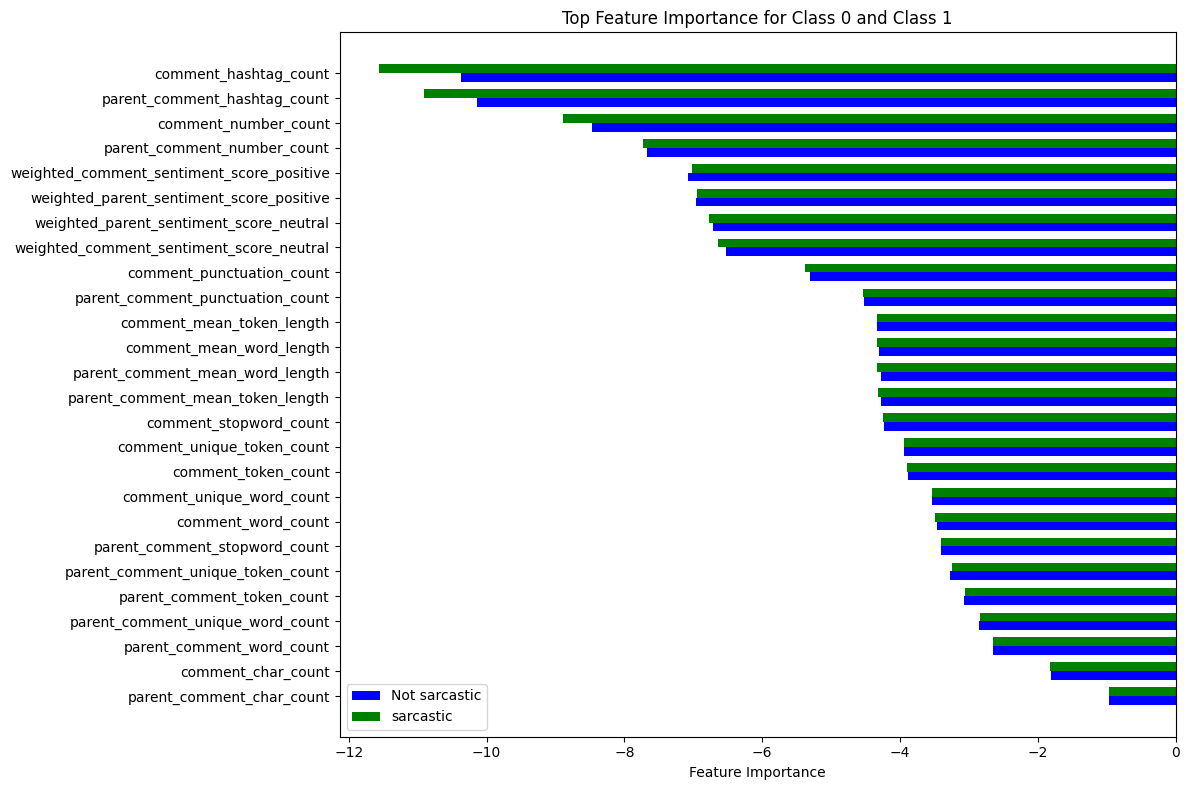

In [24]:
# Get the feature log probabilities (coefficients) from the model
feature_log_prob = model.feature_log_prob_

# Mapping feature names to importance scores
feature_importance_dict0 = dict(zip(list_of_features, feature_log_prob[0]))
feature_importance_dict1 = dict(zip(list_of_features, feature_log_prob[1]))

# Sort the features by their importance scores for class 0
sorted_features_0 = sorted(feature_importance_dict0.items(), key=lambda x: x[1], reverse=True)
top_features_0 = len(list_of_features)  # Choose how many top features to display for class 0
top_features_names_0 = [feat[0] for feat in sorted_features_0[:top_features_0]]
top_features_scores_0 = [feat[1] for feat in sorted_features_0[:top_features_0]]

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = len(list_of_features)  # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = top_features_0 
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index, top_features_scores_0, bar_width, label='Not sarcastic', color='blue')
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_0)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
sorted_features_0

[('parent_comment_char_count', -0.9736845020601379),
 ('comment_char_count', -1.8017598289800763),
 ('parent_comment_word_count', -2.649780589998132),
 ('parent_comment_unique_word_count', -2.8569752796376946),
 ('parent_comment_token_count', -3.071976238712681),
 ('parent_comment_unique_token_count', -3.2731292392635165),
 ('parent_comment_stopword_count', -3.405302185109832),
 ('comment_word_count', -3.462934995709343),
 ('comment_unique_word_count', -3.536649317514355),
 ('comment_token_count', -3.878058242962796),
 ('comment_unique_token_count', -3.939032956332822),
 ('comment_stopword_count', -4.225249256726416),
 ('parent_comment_mean_token_length', -4.273052593473805),
 ('parent_comment_mean_word_length', -4.277668486462744),
 ('comment_mean_word_length', -4.304764717777632),
 ('comment_mean_token_length', -4.326933094074182),
 ('parent_comment_punctuation_count', -4.525400951581188),
 ('comment_punctuation_count', -5.3045999696360635),
 ('weighted_comment_sentiment_score_neutra

In [26]:
sorted_features_1

[('parent_comment_char_count', -0.9645494022714853),
 ('comment_char_count', -1.8160658034026689),
 ('parent_comment_word_count', -2.6476519170132384),
 ('parent_comment_unique_word_count', -2.8417392084997015),
 ('parent_comment_token_count', -3.0627177538778945),
 ('parent_comment_unique_token_count', -3.2508446871809085),
 ('parent_comment_stopword_count', -3.4113078502550103),
 ('comment_word_count', -3.486783276656631),
 ('comment_unique_word_count', -3.535884656452035),
 ('comment_token_count', -3.9023567488200186),
 ('comment_unique_token_count', -3.9423032747271876),
 ('comment_stopword_count', -4.247481994474555),
 ('parent_comment_mean_token_length', -4.3178241007120235),
 ('comment_mean_token_length', -4.3266227953627805),
 ('parent_comment_mean_word_length', -4.32824824661691),
 ('comment_mean_word_length', -4.332264496293748),
 ('parent_comment_punctuation_count', -4.533233121383107),
 ('comment_punctuation_count', -5.371791339102835),
 ('weighted_comment_sentiment_score_n

### Baseline 5: General Features + TF-IDF

Performing Multinomial Naive Bayes classification using General Features and Comment TF-IDF as the baseline.

In [27]:
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr])

In [28]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5856576299149585
Standard Deviation of roc_auc: 0.01455822864352804


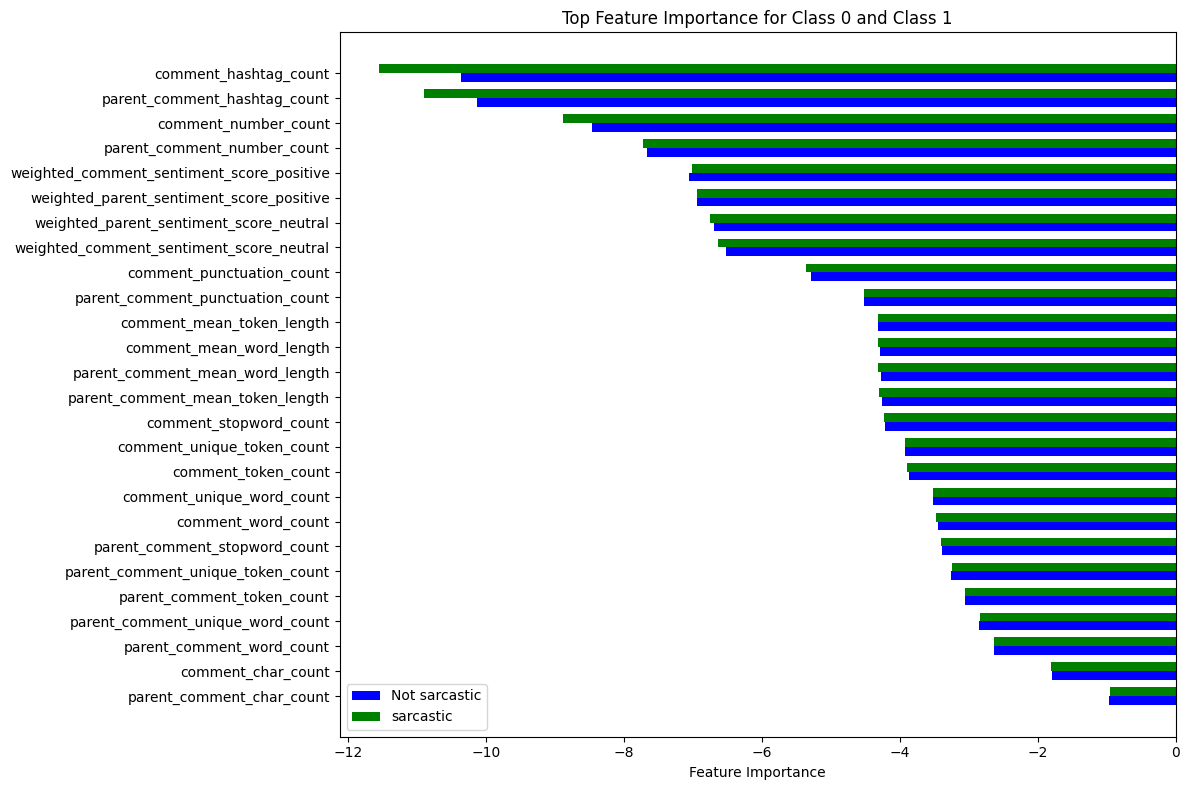

In [29]:
# Get the feature log probabilities (coefficients) from the model
feature_log_prob = model.feature_log_prob_

# Mapping feature names to importance scores
feature_importance_dict0 = dict(zip(list_of_features, feature_log_prob[0]))
feature_importance_dict1 = dict(zip(list_of_features, feature_log_prob[1]))

# Sort the features by their importance scores for class 0
sorted_features_0 = sorted(feature_importance_dict0.items(), key=lambda x: x[1], reverse=True)
top_features_0 = len(list_of_features)  # Choose how many top features to display for class 0
top_features_names_0 = [feat[0] for feat in sorted_features_0[:top_features_0]]
top_features_scores_0 = [feat[1] for feat in sorted_features_0[:top_features_0]]

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = len(list_of_features)  # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = top_features_0 
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index, top_features_scores_0, bar_width, label='Not sarcastic', color='blue')
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_0)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
sorted_features_0

[('parent_comment_char_count', -0.9609352294060187),
 ('comment_char_count', -1.789010556325957),
 ('parent_comment_word_count', -2.6370313173440127),
 ('parent_comment_unique_word_count', -2.8442260069835754),
 ('parent_comment_token_count', -3.059226966058562),
 ('parent_comment_unique_token_count', -3.2603799666093973),
 ('parent_comment_stopword_count', -3.392552912455713),
 ('comment_word_count', -3.450185723055224),
 ('comment_unique_word_count', -3.523900044860236),
 ('comment_token_count', -3.8653089703086767),
 ('comment_unique_token_count', -3.9262836836787027),
 ('comment_stopword_count', -4.212499984072297),
 ('parent_comment_mean_token_length', -4.260303320819686),
 ('parent_comment_mean_word_length', -4.264919213808625),
 ('comment_mean_word_length', -4.292015445123512),
 ('comment_mean_token_length', -4.3141838214200625),
 ('parent_comment_punctuation_count', -4.512651678927069),
 ('comment_punctuation_count', -5.291850696981944),
 ('weighted_comment_sentiment_score_neut

In [31]:
sorted_features_1

[('parent_comment_char_count', -0.9514086238885948),
 ('comment_char_count', -1.8029250250197784),
 ('parent_comment_word_count', -2.634511138630348),
 ('parent_comment_unique_word_count', -2.828598430116811),
 ('parent_comment_token_count', -3.049576975495004),
 ('parent_comment_unique_token_count', -3.237703908798018),
 ('parent_comment_stopword_count', -3.3981670718721197),
 ('comment_word_count', -3.4736424982737404),
 ('comment_unique_word_count', -3.5227438780691447),
 ('comment_token_count', -3.889215970437128),
 ('comment_unique_token_count', -3.929162496344297),
 ('comment_stopword_count', -4.234341216091664),
 ('parent_comment_mean_token_length', -4.304683322329133),
 ('comment_mean_token_length', -4.31348201697989),
 ('parent_comment_mean_word_length', -4.31510746823402),
 ('comment_mean_word_length', -4.319123717910857),
 ('parent_comment_punctuation_count', -4.520092343000217),
 ('comment_punctuation_count', -5.358650560719944),
 ('weighted_comment_sentiment_score_neutral'

### Baseline 6: Gen Features + Comment TDIDF + Parent TDIDF

Performing Multinomial Naive Bayes classification using General Features, Comment TF-IDF and Parent comment TF-IDF as the baseline.

In [32]:
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr,train_parent_tdidf_csr])

In [33]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5976400104468006
Standard Deviation of roc_auc: 0.014213097801530149


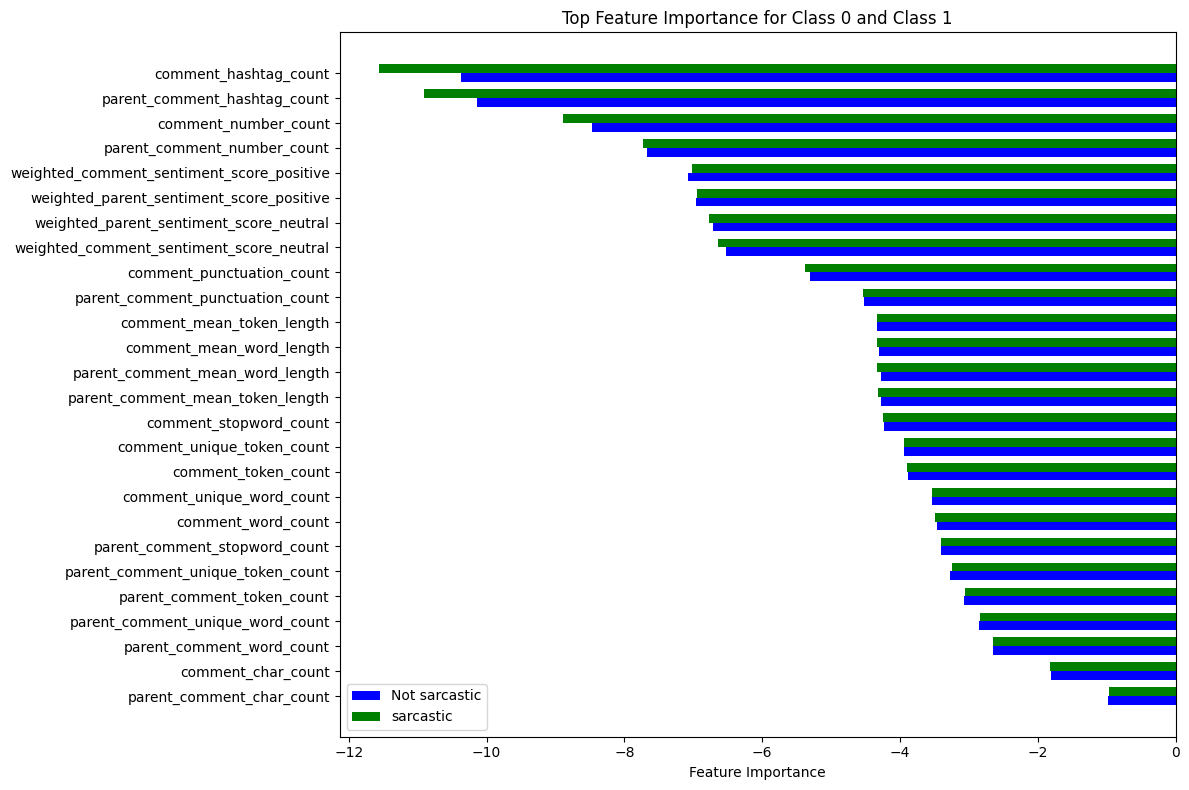

In [34]:
# Get the feature log probabilities (coefficients) from the model
feature_log_prob = model.feature_log_prob_

# Mapping feature names to importance scores
feature_importance_dict0 = dict(zip(list_of_features, feature_log_prob[0]))
feature_importance_dict1 = dict(zip(list_of_features, feature_log_prob[1]))

# Sort the features by their importance scores for class 0
sorted_features_0 = sorted(feature_importance_dict0.items(), key=lambda x: x[1], reverse=True)
top_features_0 = len(list_of_features)  # Choose how many top features to display for class 0
top_features_names_0 = [feat[0] for feat in sorted_features_0[:top_features_0]]
top_features_scores_0 = [feat[1] for feat in sorted_features_0[:top_features_0]]

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = len(list_of_features)  # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = top_features_0 
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index, top_features_scores_0, bar_width, label='Not sarcastic', color='blue')
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_0)
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
sorted_features_0

[('parent_comment_char_count', -0.9746731136679614),
 ('comment_char_count', -1.8027484405878997),
 ('parent_comment_word_count', -2.6507692016059554),
 ('parent_comment_unique_word_count', -2.857963891245518),
 ('parent_comment_token_count', -3.0729648503205045),
 ('parent_comment_unique_token_count', -3.27411785087134),
 ('parent_comment_stopword_count', -3.4062907967176557),
 ('comment_word_count', -3.4639236073171666),
 ('comment_unique_word_count', -3.5376379291221784),
 ('comment_token_count', -3.8790468545706194),
 ('comment_unique_token_count', -3.9400215679406454),
 ('comment_stopword_count', -4.226237868334239),
 ('parent_comment_mean_token_length', -4.2740412050816285),
 ('parent_comment_mean_word_length', -4.278657098070568),
 ('comment_mean_word_length', -4.305753329385455),
 ('comment_mean_token_length', -4.327921705682005),
 ('parent_comment_punctuation_count', -4.526389563189012),
 ('comment_punctuation_count', -5.305588581243887),
 ('weighted_comment_sentiment_score_ne

In [36]:
sorted_features_1

[('parent_comment_char_count', -0.9654874955642629),
 ('comment_char_count', -1.8170038966954465),
 ('parent_comment_word_count', -2.648590010306016),
 ('parent_comment_unique_word_count', -2.842677301792479),
 ('parent_comment_token_count', -3.063655847170672),
 ('parent_comment_unique_token_count', -3.251782780473686),
 ('parent_comment_stopword_count', -3.412245943547788),
 ('comment_word_count', -3.4877213699494085),
 ('comment_unique_word_count', -3.536822749744813),
 ('comment_token_count', -3.903294842112796),
 ('comment_unique_token_count', -3.943241368019965),
 ('comment_stopword_count', -4.248420087767332),
 ('parent_comment_mean_token_length', -4.318762194004801),
 ('comment_mean_token_length', -4.327560888655558),
 ('parent_comment_mean_word_length', -4.329186339909688),
 ('comment_mean_word_length', -4.333202589586525),
 ('parent_comment_punctuation_count', -4.534171214675885),
 ('comment_punctuation_count', -5.372729432395612),
 ('weighted_comment_sentiment_score_neutral'

### Baseline 7: Gen + Parent TDIDF

Performing Multinomial Naive Bayes classification using General Features and Parent comment TF-IDF as the baseline.

In [37]:
X_train_LR = hstack([X_train_gen_features,train_parent_tdidf_csr])

In [38]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5272753565019327
Standard Deviation of roc_auc: 0.006666106199031639


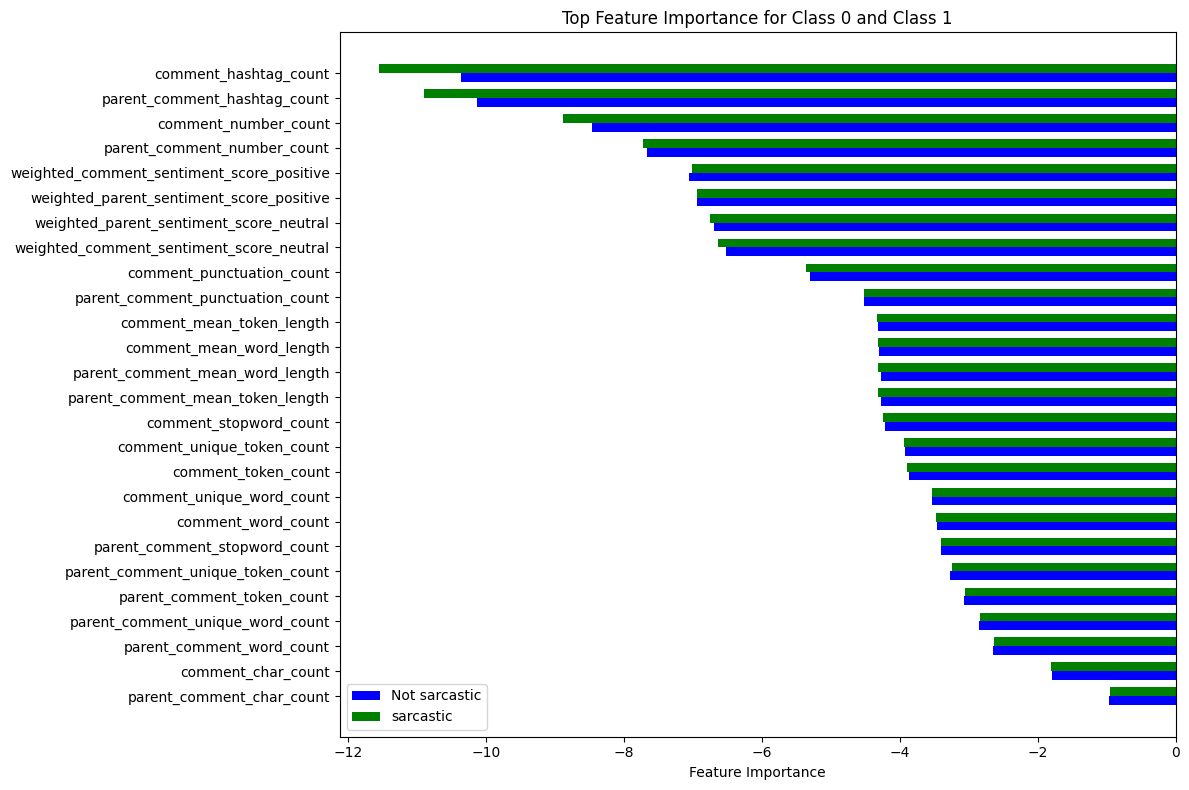

In [39]:
# Get the feature log probabilities (coefficients) from the model
feature_log_prob = model.feature_log_prob_

# Mapping feature names to importance scores
feature_importance_dict0 = dict(zip(list_of_features, feature_log_prob[0]))
feature_importance_dict1 = dict(zip(list_of_features, feature_log_prob[1]))

# Sort the features by their importance scores for class 0
sorted_features_0 = sorted(feature_importance_dict0.items(), key=lambda x: x[1], reverse=True)
top_features_0 = len(list_of_features)  # Choose how many top features to display for class 0
top_features_names_0 = [feat[0] for feat in sorted_features_0[:top_features_0]]
top_features_scores_0 = [feat[1] for feat in sorted_features_0[:top_features_0]]

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = len(list_of_features)  # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = top_features_0 
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index, top_features_scores_0, bar_width, label='Not sarcastic', color='blue')
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_0)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
sorted_features_0

[('parent_comment_char_count', -0.966327043602103),
 ('comment_char_count', -1.7944023705220413),
 ('parent_comment_word_count', -2.642423131540097),
 ('parent_comment_unique_word_count', -2.8496178211796597),
 ('parent_comment_token_count', -3.064618780254646),
 ('parent_comment_unique_token_count', -3.2657717808054816),
 ('parent_comment_stopword_count', -3.3979447266517973),
 ('comment_word_count', -3.4555775372513082),
 ('comment_unique_word_count', -3.52929185905632),
 ('comment_token_count', -3.870700784504761),
 ('comment_unique_token_count', -3.931675497874787),
 ('comment_stopword_count', -4.217891798268381),
 ('parent_comment_mean_token_length', -4.26569513501577),
 ('parent_comment_mean_word_length', -4.270311028004709),
 ('comment_mean_word_length', -4.297407259319597),
 ('comment_mean_token_length', -4.319575635616147),
 ('parent_comment_punctuation_count', -4.5180434931231535),
 ('comment_punctuation_count', -5.297242511178029),
 ('weighted_comment_sentiment_score_neutral

In [41]:
sorted_features_1

[('parent_comment_char_count', -0.9567697491648648),
 ('comment_char_count', -1.8082861502960483),
 ('parent_comment_word_count', -2.639872263906618),
 ('parent_comment_unique_word_count', -2.833959555393081),
 ('parent_comment_token_count', -3.054938100771274),
 ('parent_comment_unique_token_count', -3.243065034074288),
 ('parent_comment_stopword_count', -3.4035281971483897),
 ('comment_word_count', -3.4790036235500104),
 ('comment_unique_word_count', -3.5281050033454147),
 ('comment_token_count', -3.894577095713398),
 ('comment_unique_token_count', -3.934523621620567),
 ('comment_stopword_count', -4.239702341367934),
 ('parent_comment_mean_token_length', -4.310044447605403),
 ('comment_mean_token_length', -4.31884314225616),
 ('parent_comment_mean_word_length', -4.32046859351029),
 ('comment_mean_word_length', -4.324484843187127),
 ('parent_comment_punctuation_count', -4.525453468276487),
 ('comment_punctuation_count', -5.364011685996214),
 ('weighted_comment_sentiment_score_neutral'

### Hyper Parameter Tuning with Grid Search CV

Baseline 5: General Features + BoW has the highest mean roc_auc score (0.63460). This means that it is the best performing classifier. We will now perform hyperparameter tuning on this to increase the model performance. We will use GridSearchCV to cross validate all possible hyperparameter combinations and pick the best performing hyperparameters.

In [42]:
### Using gen features and bow
X_train_LR = hstack([X_train_gen_features,train_bow_csr])

In [43]:
param_grid = {
    'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],  # You can extend this list
    'fit_prior': [True, False],
}


In [44]:
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='roc_auc', verbose=4)
grid_search.fit(X_train_LR, y_train_LR)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .........alpha=0.2, fit_prior=True;, score=0.688 total time=   0.1s
[CV 2/5] END .........alpha=0.2, fit_prior=True;, score=0.666 total time=   0.0s
[CV 3/5] END .........alpha=0.2, fit_prior=True;, score=0.681 total time=   0.0s
[CV 4/5] END .........alpha=0.2, fit_prior=True;, score=0.684 total time=   0.0s
[CV 5/5] END .........alpha=0.2, fit_prior=True;, score=0.681 total time=   0.0s
[CV 1/5] END ........alpha=0.2, fit_prior=False;, score=0.688 total time=   0.0s
[CV 2/5] END ........alpha=0.2, fit_prior=False;, score=0.666 total time=   0.0s
[CV 3/5] END ........alpha=0.2, fit_prior=False;, score=0.681 total time=   0.0s
[CV 4/5] END ........alpha=0.2, fit_prior=False;, score=0.684 total time=   0.0s
[CV 5/5] END ........alpha=0.2, fit_prior=False;, score=0.681 total time=   0.0s
[CV 1/5] END .........alpha=0.4, fit_prior=True;, score=0.690 total time=   0.0s
[CV 2/5] END .........alpha=0.4, fit_prior=True;

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'fit_prior': [True, False]},
             scoring='roc_auc', verbose=4)

In [45]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Best score achieved during grid search
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'alpha': 0.6, 'fit_prior': True}
Best Score: 0.6819322827550783


Here we will test out the model using the best hyperparameters.

In [46]:
# Best estimator (the fitted model with the best parameters)
best_estimator = grid_search.best_estimator_
print("Best Estimator:", best_estimator)

# Results for all parameter combinations
cv_results = grid_search.cv_results_

Best Estimator: MultinomialNB(alpha=0.6)


In [47]:
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']
params = cv_results['params']

pd.set_option('display.max_colwidth',None)
results_df = pd.DataFrame({'Params':params,'Mean Score':mean_test_scores,'STD':std_test_scores})
results_df["Params"] = results_df["Params"].apply(lambda x: ', '.join([f'{key}: {value}' for key, value in x.items()]))
results_df.sort_values('STD', inplace=True)
results_df.sort_values('Mean Score', ascending=False,inplace=True)
results_df


#for mean_score, std_score, param in zip(mean_test_scores, std_test_scores, params):
    #print(f"Mean Score: {mean_score:.3f} (±{std_score:.3f}) for params: {param}")

,Params,Mean Score,STD
4,"alpha: 0.6, fit_prior: True",0.681932,0.008536
5,"alpha: 0.6, fit_prior: False",0.681932,0.008536
6,"alpha: 0.8, fit_prior: True",0.681787,0.008815
7,"alpha: 0.8, fit_prior: False",0.681787,0.008815
2,"alpha: 0.4, fit_prior: True",0.681644,0.008160
3,"alpha: 0.4, fit_prior: False",0.681644,0.008160
8,"alpha: 1.0, fit_prior: True",0.681450,0.009036
9,"alpha: 1.0, fit_prior: False",0.681450,0.009036
0,"alpha: 0.2, fit_prior: True",0.680133,0.007558
1,"alpha: 0.2, fit_prior: False",0.680133,0.007558


### Compare to Test Set

Here we can see that hyperparameter tuning has increased the ROC_AUC score from 0.63460 to 0.64008.

In [48]:
X_test_LR = hstack([X_test_gen_features,test_bow_csr])
#X_test_LR = scaler.fit_transform(X_test_LR)

In [49]:
y_pred_test = best_estimator.predict(X_test_LR)
roc_auc_test = roc_auc_score(y_test_LR, y_pred_test)
print(f"roc_auc test: {roc_auc_test}")

roc_auc test: 0.6398838026998598
